In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import njit, prange
import time

# Save results on S3

# 1. Simulate data

$$y_t = u'_t \phi + x'_t \beta + \epsilon_t, \epsilon_t \stackrel{\text{i.i.d}}{\sim} \mathcal{N}(0, \sigma^{2}) $$
In our case, as the dimension of U is l = 0, we have 
$$y_t = x'_t \beta + \epsilon_t, \epsilon_t \stackrel{\text{i.i.d}}{\sim} \mathcal{N}(0, \sigma^{2}) $$

In [2]:
l = 0
k = 100
T = 200

In [3]:
a, b, A, B = 1, 1, 1, 1

### Draw initial q

In [4]:
def draw_initial_q(a=a, b=b):
    return np.random.beta(a, b)

### Draw initial $R²$

In [5]:
def draw_initial_R2(A=A, B=B):
    return np.random.beta(A, B)

### Compute initial $\gamma^2$

In [6]:
@njit
def compute_gamma2(X, r2, q, v_x_bar, k=k):
    denominator = q * k * v_x_bar * (1-r2)
    return r2 / denominator

### Draw initial $\sigma²$

In [7]:
def draw_inital_sigma_squared(X, beta, Ry, T=T):
    return ((1/Ry) - 1) * (1/T) * sum([(beta.T @ x)**2 for x in X])

### Draw initial $\beta$

In [8]:
def draw_initial_beta(s, k=k):
    beta = np.random.normal(size=k)
    indices_null = np.random.choice(range(k), size=k-s, replace=False)
    beta[indices_null] = 0
    z = np.ones(k)
    z[indices_null] = 0
    return beta, z

### Simulate X

In [9]:
from scipy.linalg import toeplitz

In [10]:
rho = 0.75

In [11]:
def draw_X(rho=rho, k=k, T=T):
    correlation_matrix = toeplitz(rho ** np.arange(0, k))
    X = np.random.multivariate_normal(np.zeros(k), correlation_matrix, size=T)
    for i in range(len(X)):
        X[i] = (X[i] - X[i].mean()) / np.std(X[i])
    return X

### Simulate Y

In [12]:
def draw_Y(X, beta, sigma_squared):
    return X @ beta + np.random.normal(0, sigma_squared, size=(X @ beta).shape[0])

In [13]:
def draw_dataset(Ry, s, rho=rho, k=k, T=T):
    X = draw_X()
    beta, z = draw_initial_beta(s, k=k)
    sigma_squared = draw_inital_sigma_squared(X, beta, Ry, T=T)
    Y = draw_Y(X, beta, sigma_squared)
    return Y, X, beta, sigma_squared, z

# 2. Draw from posteriors

In [14]:
# def inverse_matrix(A):
#     try:
#         return np.linalg.solve(A, np.eye(A.shape[0]))
#     except:
#         return A
@njit(nogil=True)
def inverse_matrix(A):
    return np.linalg.inv(A)

In [15]:
@njit(nogil=True)
def draw_tildes(Y, X, beta, gamma2, z):
    X_tilde = X[:, z != 0]
    beta_tilde = beta[z != 0]
    W_tilde = X_tilde.T @ X_tilde + (1/gamma2) * np.eye(int(np.sum(z)))
    Y_tilde = Y 
    inverse_W_tilde = inverse_matrix(W_tilde)
    beta_tilde_hat = inverse_W_tilde @ X_tilde.T @ Y_tilde
    return X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat, inverse_W_tilde

### (I). Draw from $R²$

In [16]:
@njit(nogil=True, parallel=True)
def draw_r2(X, z, beta, sigma_squared, v_x_bar, q_grid):
    s_z = np.sum(z)
    r2_grid = q_grid
    posterior = np.zeros((len(q_grid), len(r2_grid)))
    
    #beta_term = (beta.T @ np.diag(z) @ beta)
    beta_term = np.dot(np.dot(beta.T.astype(np.float64), np.diag(z).astype(np.float64)), beta.astype(np.float64))
    sum_posterior = 0
    
    for i in prange(len(q_grid)):
        q_loop = q_grid[i]
        q_term = q_loop ** (s_z + s_z/2 + a - 1) * (1-q_loop) ** (k - s_z + b - 1)
        
        for j in range(len(r2_grid)):
            r2_loop = r2_grid[j]
            
            exp_term = np.exp((-1/(2*sigma_squared)) * ((k * v_x_bar * q_loop * (1 - r2_loop)) / r2_loop) * beta_term)
            r2_term = r2_loop ** (A - 1 - s_z/2) * (1-r2_loop) ** (s_z/2 + B - 1)
            posterior[i, j] = exp_term * q_term * r2_term
            sum_posterior += posterior[i, j]
    
    # normalize the posterior
    posterior = posterior.flatten() / sum_posterior
    x = np.argmax(np.random.multinomial(1, posterior))
    i, j = x // len(q_grid), x % len(r2_grid)
    sampled_q = q_grid[i]
    sampled_r2 = r2_grid[j]
    return sampled_r2, sampled_q

In [30]:
@njit
def draw_r2_np_gpt(X, z, beta, sigma_squared, v_x_bar, q_grid):
    s_z = np.sum(z)
    r2_grid = q_grid
    posterior = np.zeros((len(q_grid), len(r2_grid)))

    #beta_term = (beta.T @ np.diag(z) @ beta)
    beta_term = np.dot(np.dot(beta.T.astype(np.float64), np.diag(z).astype(np.float64)), beta.astype(np.float64))

    q_term = q_grid ** (s_z + s_z/2 + a - 1) * (1 - q_grid) ** (k - s_z + b - 1)

    for j, r2_loop in enumerate(r2_grid):
        exp_term = np.exp((-1/(2*sigma_squared)) * ((k * v_x_bar * q_grid * (1 - r2_loop)) / r2_loop) * beta_term)
        r2_term = r2_loop ** (A - 1 - s_z/2) * (1 - r2_loop) ** (s_z/2 + B - 1)
        posterior[:, j] = exp_term * q_term * r2_term

    # normalize the posterior
    posterior = posterior.flatten() / posterior.sum()
    x = np.argmax(np.random.multinomial(1, posterior))
    i, j = x // len(q_grid), x % len(r2_grid)
    sampled_q = q_grid[i]
    sampled_r2 = r2_grid[j]
    return sampled_r2, sampled_q, posterior

In [40]:
def draw_r2_full(X, z, beta, sigma_squared, v_x_bar, q_grid):
    s_z = np.sum(z)
    r2_grid = q_grid
    posterior = np.zeros((len(q_grid), len(r2_grid)))

    #beta_term = (beta.T @ np.diag(z) @ beta)
    beta_term = np.dot(np.dot(beta.T.astype(np.float64), np.diag(z).astype(np.float64)), beta.astype(np.float64))

    q_term = q_grid ** (s_z + s_z/2 + a - 1) * (1 - q_grid) ** (k - s_z + b - 1)

    r2_term = r2_grid[:, np.newaxis] ** (A - 1 - s_z/2) * (1 - r2_grid[:, np.newaxis]) ** (s_z/2 + B - 1)

    exp_term = np.exp((-1/(2*sigma_squared)) * ((k * v_x_bar * q_grid * (1 - r2_grid[:, np.newaxis])) / r2_grid[:, np.newaxis]) * beta_term)

    posterior = exp_term * q_term * r2_term
    posterior = posterior.flatten() / posterior.sum()
    return posterior

In [45]:
%timeit draw_r2_np_gpt(X, z, beta, sigma_squared, v_x_bar, q_grid)

4.83 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%timeit draw_r2_full(X, z, beta, sigma_squared, v_x_bar, q_grid)

1.37 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
draw_r2_np_gpt(X, z, beta, sigma_squared, v_x_bar, q_grid)

(0.5399999999999998, 0.095)

In [29]:
%timeit draw_r2_np_gpt(X, z, beta, sigma_squared, v_x_bar, q_grid)

4.94 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### (III). Draw from z

In [17]:
import scipy.special as sp

In [18]:
@njit
def norm_1(matrix):
    norm_1 = np.sum(np.abs(matrix), axis=0).max()
    return norm_1

@njit
def bernouilli(q):
    u = np.random.uniform(0, 1)
    return 1 if u < q else 0

In [19]:
@njit
def draw_zi(Y, X, beta, gamma2, z, i, q, var, norm, k=k, T=T):
    if z[i] == 0:
        is0 = True
        z[i] = 1
    else:
        is0 = False
        z[i] = 0
        
    X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat, inverse_W_tilde = draw_tildes(Y, X, beta, gamma2, z)
    false_var = (Y_tilde.T @ Y_tilde - beta_tilde_hat.T @ W_tilde @ beta_tilde_hat)
    false_norm = norm_1(W_tilde)
    
    power_is0 = (-1) if is0 else 1
    denominator = (1-q)/q * np.sqrt(gamma2) * (norm/false_norm) ** (power_is0 * 1/2) * (var/false_var) ** (power_is0 * T/2)
    proba_success = 1 / (1 + denominator)
    
    return bernouilli(proba_success)

In [20]:
@njit(nogil=True, parallel=True)
def draw_z(Y, X, beta, gamma2, z, q, k=k, T=T):
    sampled_z = np.zeros(z.shape)
    
    X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat, inverse_W_tilde = draw_tildes(Y, X, beta, gamma2, z)
    var = (Y_tilde.T @ Y_tilde - beta_tilde_hat.T @ W_tilde @ beta_tilde_hat)
    norm = norm_1(W_tilde)
    
    for i in prange(len(z)):
        z_copy = z.copy()
        sampled_z[i] = draw_zi(Y, X, beta, gamma2, z_copy, i, q, var, norm, k=k, T=T)
    return sampled_z

### (IV). Draw from $\sigma²$

In [21]:
import scipy.stats as stats

In [22]:
@njit
def var_sigma_squared(Y, X, beta, gamma2, z):
    X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat, inverse_W_tilde = draw_tildes(Y, X, beta, gamma2, z)
    variance = (1/2) * (Y_tilde.T @ Y_tilde - beta_tilde_hat.T @ W_tilde @ beta_tilde_hat)
    return variance

def draw_sigma(Y, X, beta, gamma2, z):
    # X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat = draw_tildes(Y, X, beta, gamma2, z)
    # variance = (1/2) * (Y_tilde.T @ Y_tilde - beta_tilde_hat.T @ W_tilde @ beta_tilde_hat)
    variance = var_sigma_squared(Y, X, beta, gamma2, z)
    return stats.invgamma.rvs(T/2, variance)

### (V). Draw from $\tilde{\beta}$

In [23]:
def reconstruct_beta(beta_tilde, z, k=k):
    reconstructed_beta = np.zeros(k)
    reconstructed_beta[z != 0] = beta_tilde
    return reconstructed_beta

In [24]:
@njit
def mean_var_beta_tilde(Y, X, beta, gamma2, z, sigma_squared):
    X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat, inverse_W_tilde = draw_tildes(Y, X, beta, gamma2, z)
    mean = beta_tilde_hat
    variance = sigma_squared * inverse_W_tilde
    return mean, variance

def draw_beta_tilde(Y, X, beta, gamma2, z, sigma_squared):
    # X_tilde, beta_tilde, W_tilde, Y_tilde, beta_tilde_hat = draw_tildes(Y, X, beta, gamma2, z)
    # mean = inverse_matrix(W_tilde) @ X_tilde.T @ Y_tilde
    # variance = sigma_squared * inverse_matrix(W_tilde)
    mean, variance = mean_var_beta_tilde(Y, X, beta, gamma2, z, sigma_squared)
    return np.random.multivariate_normal(mean, variance)

# 3. Gibbs Sampler

In [25]:
import multiprocessing
from multiprocessing import Pool

In [26]:
n_iter = 110_000
burn_in = 10_000
nb_cpu_cores = multiprocessing.cpu_count()
print(f"Nb CPU cores: {nb_cpu_cores}")

Nb CPU cores: 72


In [46]:
def gibbs_sampler(Ry, s, n_iter=n_iter, burn_in=10_000, k=k, T=T, a=a, b=b, A=A, B=B, display_=False):
    print(Ry, s)
    ### initialize dataset ###
    q = draw_initial_q(a=a, b=b)
    r2 = draw_initial_R2(A=A, B=B)
    Y, X, beta, sigma_squared, z = draw_dataset(Ry, s, rho=rho, k=k, T=T)
    v_x_bar = (1/k) * sum([np.var(x) for x in X])
    gamma2 = compute_gamma2(X, r2, q, v_x_bar, k=k)
    q_grid = np.concatenate((np.arange(0.001, 0.1, 0.001), np.arange(0.1, 0.9, 0.01), np.arange(0.9, 1, 0.001)))
    
    parameters = {}
    parameters['sigma_squared'] = []
    parameters['r2'] = []
    parameters['q'] = []
    
    times = {}
    times['r2'] = []
    times['z'] = []
    times['sigma'] = []
    times['beta_tilde'] = []
    times['beta'] = []
    times['gamma'] = []
    
    range_ = tqdm(range(n_iter)) if display_ else range(n_iter)
    for i in range_:
        t1 = time.time()
        r2, q = draw_r2(X, z, beta, sigma_squared, v_x_bar, q_grid)
        t2 = time.time()
        z = draw_z(Y, X, beta, gamma2, z, q, k=k, T=T)
        t3 = time.time()
        sigma_squared = draw_sigma(Y, X, beta, gamma2, z)
        t4 = time.time()
        beta_tilde = draw_beta_tilde(Y, X, beta, gamma2, z, sigma_squared)
        t5 = time.time()

        if i >= burn_in:
            parameters['sigma_squared'].append(sigma_squared)
            parameters['r2'].append(r2)
            parameters['q'].append(q)
        
        # reconstruct beta from drawn beta_tilde and z
        t6 = time.time()
        beta = reconstruct_beta(beta_tilde, z, k=k)
        t7 = time.time()
        gamma2 = compute_gamma2(X, r2, q, v_x_bar, k=k)
        t8 = time.time()
        
        times['r2'].append(t2-t1)
        times['z'].append(t3-t2)
        times['sigma'].append(t4-t3)
        times['beta_tilde'].append(t5-t4)
        times['beta'].append(t7-t6)
        times['gamma'].append(t8-t7)

        #print(f"r2: {r(t2 - t1)}, z: {r(t3-t2)}, sigma: {r(t4-t3)}, beta_tilde: {r(t5-t4)}, recons beta: {r(t7-t6)}, compute gamma: {r(t8-t7)}")
        
    return parameters, beta, times

### Run Gibbs sampler for each dataset

In [28]:
all_values = []
Ry_values = [0.02, 0.25, 0.5]
s_values = [5, 10, 100]
for Ry in Ry_values:
    for s in s_values:
        all_values.append((Ry, s))
print(all_values)

[(0.02, 5), (0.02, 10), (0.02, 100), (0.25, 5), (0.25, 10), (0.25, 100), (0.5, 5), (0.5, 10), (0.5, 100)]


In [29]:
range_ = range(0, 3)

In [ ]:
for i in range_:
    Ry, s = all_values[i]
    params, f_beta = gibbs_sampler(Ry, s, n_iter=n_iter, burn_in=burn_in, k=k, T=T, a=a, b=b, A=A, B=B, display_=True)
    #dict_results = load_dictionary()
    #dict_results[f"{Ry}, {s}"].append((params, f_beta))
    #save_dictionary(dict_results)

## Multiprocessing

In [30]:
dict_results = {}
Ry_values = [0.02, 0.25, 0.5]
s_values = [5, 10, 100]
for Ry in Ry_values:
    for s in s_values:
        dict_results[f"{Ry}, {s}"] = []

In [31]:
def draw_values(nb_iterations):
    val = []
    for _ in range(nb_iterations):
        for Ry in Ry_values:
            for s in s_values:
                val.append((Ry, s))
    return val

In [35]:
def run_multiprocessing(dict_results, nb_vals, n_iter=n_iter, burn_in=10_000, k=k, T=T, a=a, b=b, A=A, B=B):
    values = draw_values(nb_vals)[:3]
    print(values)
    
    with Pool() as p:
        async_results = [p.apply_async(gibbs_sampler, 
                                       args=(values[i][0], values[i][1], n_iter, burn_in, 
                                             k, T, a, b, A, B, i==len(values)-1)) for i in range(len(values))]
        
        for i in range(len(values)):
            print(i)
            Ry, s = values[i]
            dict_results[f"{Ry}, {s}"] = async_results[i].get()

    #return dict_results
    return None

In [ ]:
if __name__ == '__main__':
    start = time.time()
    run_multiprocessing(dict_results, 1, n_iter=1000, burn_in=100, k=k, T=T, a=a, b=b, A=A, B=B)
    stop = time.time()

In [44]:
Ry, s = 0.02, 5

In [47]:
params, f_beta, times = gibbs_sampler(Ry, s, n_iter=100, burn_in=0, k=k, T=T, a=a, b=b, A=A, B=B, display_=True)

0.02 5


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


In [49]:
for key in times.keys():
    print(key, np.mean(times[key]), np.max(times[key]))

r2 0.5314328980445862 0.5975098609924316
z 0.7372942304611206 1.296513319015503
sigma 0.16021465063095092 0.29696226119995117
beta_tilde 0.05094492197036743 0.2100081443786621
beta 3.7856101989746094e-05 0.00015473365783691406
gamma 1.697540283203125e-05 0.00010228157043457031


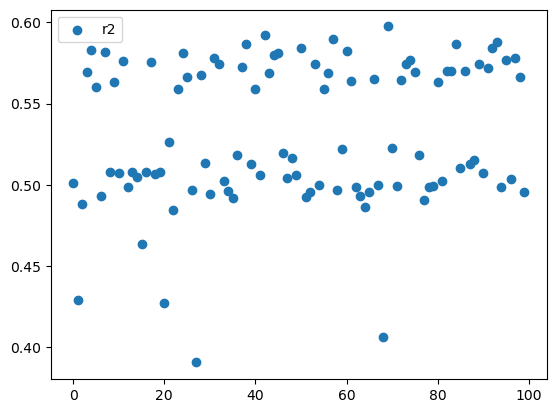

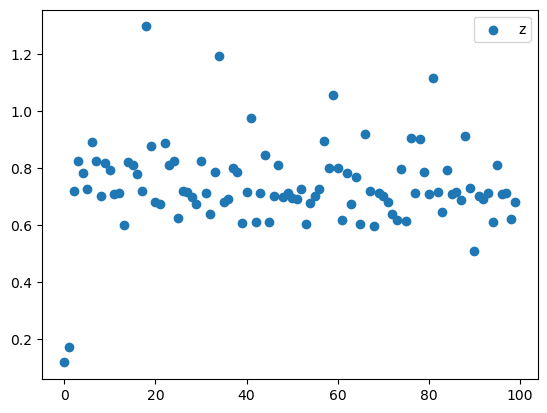

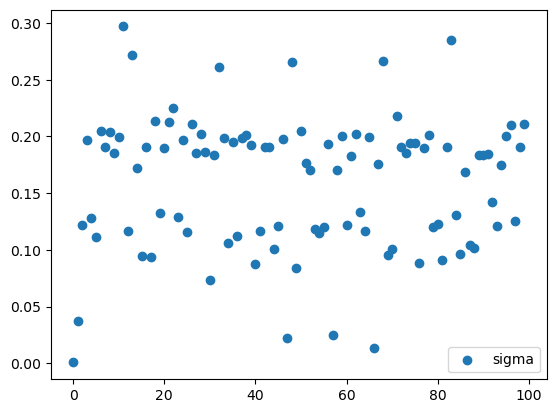

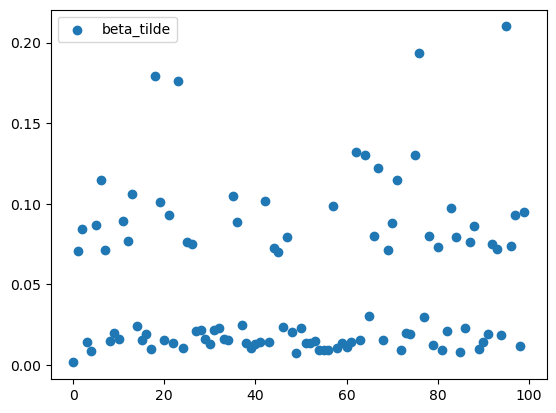

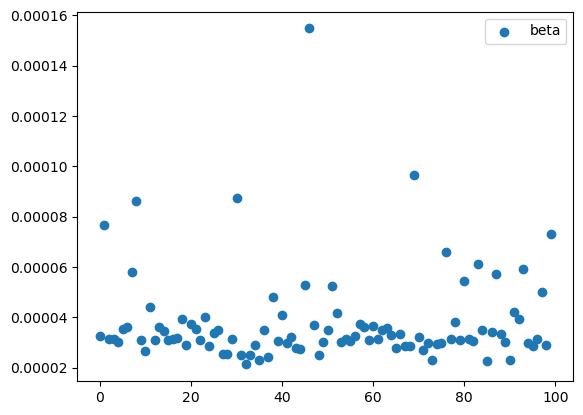

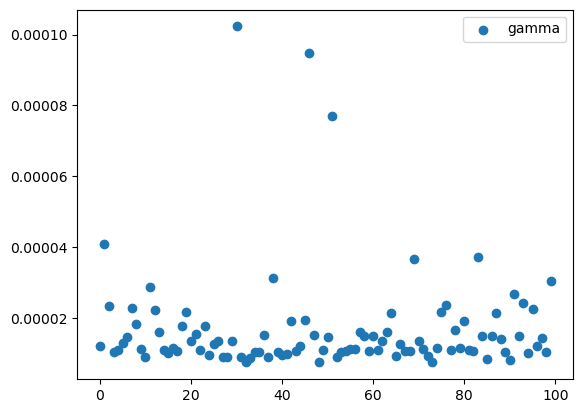

In [51]:
for key in times.keys():
    plt.scatter(range(len(times[key])), times[key], label=key)
    plt.legend()
    plt.show()
    print()

In [19]:
Ry, s = 0.25, 10

In [22]:
q = draw_initial_q(a=a, b=b)
r2 = draw_initial_R2(A=A, B=B)
Y, X, beta, sigma_squared, z = draw_dataset(Ry, s, rho=rho, k=k, T=T)
v_x_bar = (1/k) * sum([np.var(x) for x in X])
gamma2 = compute_gamma2(X, r2, q, v_x_bar, k=k)
q_grid = np.concatenate((np.arange(0.001, 0.1, 0.001), np.arange(0.1, 0.9, 0.01), np.arange(0.9, 1, 0.001)))

# range_ = tqdm(range(50))
# for i in range_:
#     r2, q = draw_r2(X, z, beta, sigma_squared, v_x_bar)
#     z = draw_z(Y, X, beta, gamma2, z, q, k=k, T=T)
#     sigma_squared = draw_sigma(Y, X, beta, gamma2, z)
#     beta_tilde = draw_beta_tilde(Y, X, beta, gamma2, z, sigma_squared)

#     beta = reconstruct_beta(beta_tilde, z, k=k)
#     gamma2 = compute_gamma2(X, r2, q, v_x_bar, k=k)

In [37]:
%timeit draw_r2(X, z, beta, sigma_squared, v_x_bar)

488 ms ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit draw_z(Y, X, beta, gamma2, z, q, k=k, T=T)

844 ms ± 59.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit draw_sigma(Y, X, beta, gamma2, z)

22.8 ms ± 9.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit draw_beta_tilde(Y, X, beta, gamma2, z, sigma_squared)

50.4 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
draw_r2(X, z, beta, sigma_squared, v_x_bar, np.concatenate((np.arange(0.001, 0.1, 0.001), np.arange(0.1, 0.9, 0.01), np.arange(0.9, 1, 0.001))))

(0.063, 0.9940000000000001)